In [27]:
import os
import torch
import trimesh
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

In [32]:
root_dir = 'datasets/simple_edge_features'  # Change this to your actual dataset path
save_dir = 'models/simple_edge_features/'
num_edges = 2048  # Predefined row length (number of rows to keep)
learning_rate = 0.001
batch_size = 32
num_epochs = 15

In [33]:
class MeshEdgesDataset(Dataset):
    def __init__(self, root_dir, num_edges, transform=None):
        self.root_dir = root_dir
        self.num_edges = num_edges
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                tensor_files = [f for f in os.listdir(class_dir) if f.endswith('.pt')]
                for tensor_file in tensor_files:
                    tensor_path = os.path.join(class_dir, tensor_file)
                    label = class_name
                    self.samples.append((tensor_path, label))

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set([s[1] for s in self.samples])))}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tensor_path, label = self.samples[idx]
        tensor = torch.load(tensor_path, weights_only=True)  # Tensor shape is (N, 7)

        if tensor.shape[0] >= self.num_edges:
            tensor = tensor[:self.num_edges, :]
        else:
            padding = torch.zeros((self.num_edges - tensor.shape[0], tensor.shape[1]))
            tensor = torch.cat((tensor, padding), dim=0)

        label_idx = self.class_to_idx[label]
        if self.transform:
            tensor = self.transform(tensor)

        tensor = tensor.clone().detach().float()
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        return tensor, label_tensor

In [34]:
# Define a simple CNN model
class MeshEdgesCNN(nn.Module):
  def __init__(self, num_classes, num_edges=1024):
    super(MeshEdgesCNN, self).__init__()
    
    self.conv1 = nn.Conv1d(in_channels=7, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(64 * (num_edges // 8), 128)  # Adjust size after pooling
    self.fc2 = nn.Linear(128, num_classes)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = x.permute(0, 2, 1)  # Convert (batch_size, num_edges, 7) to (batch_size, 7, num_edges)

    x = self.pool(self.relu(self.conv1(x)))  # (batch_size, 16, num_edges/2)
    x = self.pool(self.relu(self.conv2(x)))  # (batch_size, 32, num_edges/4)
    x = self.pool(self.relu(self.conv3(x)))  # (batch_size, 64, num_edges/8)

    x = x.view(x.size(0), -1)  # (batch_size, 64 * (num_edges // 8))

    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [35]:
dataset = MeshEdgesDataset(root_dir, num_edges)

dataset_size = len(dataset)
test_size = int(0.10 * dataset_size)
val_size = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(dataset.class_to_idx)

print(f'Number of samples: {len(dataset)}')
print(f'Classes: {dataset.class_to_idx}')
print(f'Number of classes: {num_classes}')
for i, count in enumerate(torch.bincount(torch.tensor([dataset.class_to_idx[s[1]] for s in dataset.samples]))):
    print(f'Class {i} - {dataset.idx_to_class[i]}: {count} samples')
print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))
print('Test size:', len(test_dataset))


model = MeshEdgesCNN(num_classes=num_classes, num_edges=num_edges)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Number of samples: 1850
Classes: {'bouncing': 0, 'crane': 1, 'handstand': 2, 'jumping': 3, 'march_1': 4, 'march_2': 5, 'samba': 6, 'squat_1': 7, 'squat_2': 8}
Number of classes: 9
Class 0 - bouncing: 175 samples
Class 1 - crane: 175 samples
Class 2 - handstand: 175 samples
Class 3 - jumping: 150 samples
Class 4 - march_1: 250 samples
Class 5 - march_2: 250 samples
Class 6 - samba: 175 samples
Class 7 - squat_1: 250 samples
Class 8 - squat_2: 250 samples
Train size: 1388
Validation size: 277
Test size: 185


In [ ]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(torch.float32), labels.to(torch.long)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(torch.float32), labels.to(torch.long)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'Epoch {epoch+1}/{num_epochs}, '
        f'Train Loss: {running_loss/len(train_loader):.4f}, '
        f'Validation Loss: {val_loss/len(val_loader):.4f}, '
        f'Validation Accuracy: {100 * correct / total:.2f}%')
  
  torch.save(model.state_dict(), save_dir + f'checkpoints/simple_edge_features_{epoch}.pth')
  
torch.save(model.state_dict(), save_dir + 'simple_edge_features.pth')

Test Accuracy: 99.46%


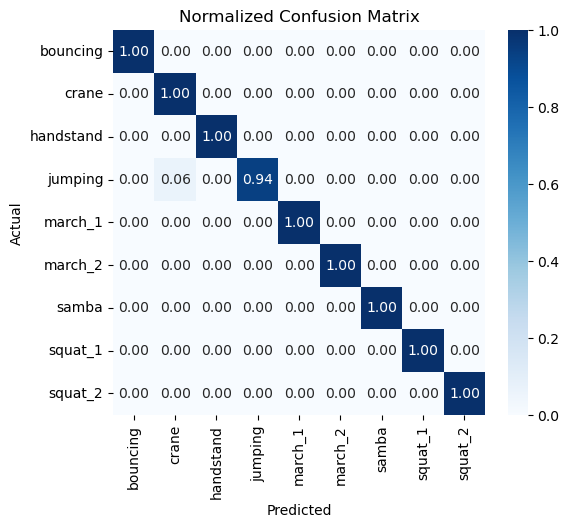

In [13]:
test_model = MeshEdgesCNN(num_classes=num_classes, num_edges=num_edges)
test_model.load_state_dict(torch.load(save_dir+'simple_edge_features.pth', weights_only=True))
test_model.eval()

correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for point_clouds, labels in test_loader:
        outputs = model(point_clouds)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize over the true labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=dataset.idx_to_class.values(), yticklabels=dataset.idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()